***Trader Behaviour and Market Sentiment Analysis Notebook***

This notebook walks through the analysis of trader data against market sentiment


1.   Import all necessary libraries.
2.   Define CSV file paths.

1.   Load the Reqiured Datasets ie. `historical_data.csv` and `fear_greed_index.csv`



1.   Run the Analysis.







In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

This cell defines the main data loading function. It reads both CSV files , performs the operation to convert dates and numbers into suitable datatype and format and merges them into a single, clean DataFrame, for analysis.

In [4]:
def load_data(trader_file, sentiment_file):
    print("Loading datasets...")
    try:
        sentiment = pd.read_csv(sentiment_file)
        trades = pd.read_csv(trader_file, low_memory=False)
    except FileNotFoundError as e:
        print(f"Error: File not found. {e}")
        return None

    print("Cleaning and preparing data...")

    sentiment['date'] = pd.to_datetime(sentiment['date'], format='%d-%m-%Y', errors='coerce') #make sure the date is in correct format.
    sentiment = sentiment[['date', 'classification']]

    trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce') #convert the timestamp into datetime format

    trades['date'] = pd.to_datetime(trades['Timestamp IST'].dt.date)

    trades['Closed PnL'] = pd.to_numeric(trades['Closed PnL'], errors='coerce')
    trades['Size USD'] = pd.to_numeric(trades['Size USD'], errors='coerce')

    trades = trades.dropna(subset=['date', 'Closed PnL', 'Size USD', 'Side'])

    print("Merging datasets...")
    merged = pd.merge(trades, sentiment, on='date', how='left')
    merged = merged.dropna(subset=['classification'])

    def simplify_sentiment(c):
        if c in ['Extreme Fear', 'Fear']:
            return 'Fear'
        if c in ['Extreme Greed', 'Greed']:
            return 'Greed'
        return 'Neutral'

    merged['Sentiment'] = merged['classification'].apply(simplify_sentiment)

    print("Data preparation complete.")
    return merged


***Analysis and Visualization function***

In [5]:
def analyze_and_visualization(df, output_path):

    if df is None or df.empty:
        print("No data.")
        return

    os.makedirs(output_path, exist_ok=True)


    sns.set_theme(style="whitegrid", palette="muted")
    sentiment_order = ['Fear', 'Neutral', 'Greed']
    sentiment_colors = ['#d9534f', '#f0ad4e', '#5cb85c']
    print("Analyzing Profits...")
    pnl_analysis = df.groupby('Sentiment')['Closed PnL'].agg(['mean', 'sum', 'count']).reindex(sentiment_order)

    print("\nAverage PnL per Trade by Sentiment:")
    print(pnl_analysis)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=pnl_analysis.index,
        y=pnl_analysis['mean'],
        order=sentiment_order,
        palette=sentiment_colors,
        hue=pnl_analysis.index,
        legend=False
    )
    plt.title('Average Closed PnL per Trade by Market Sentiment', fontsize=16, fontweight='bold')
    plt.xlabel('Market Sentiment', fontsize=12)
    plt.ylabel('Average Closed PnL ', fontsize=12)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.tight_layout()
    plt.savefig(f'{output_path}/pnl_vs_market_sentiment.png')
    plt.show()
    plt.close()

    print("\nAnalyzing Volume...")
    volume_analysis = df.groupby('Sentiment')['Size USD'].agg(['mean', 'sum']).reindex(sentiment_order)

    print("\nTotal Volume  by Sentiment:")
    print(volume_analysis)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=volume_analysis.index,
        y=volume_analysis['sum'],
        order=sentiment_order,
        palette=sentiment_colors,
        hue=volume_analysis.index,
        legend=False
    )
    plt.title('Total Trading Volume  by Market Sentiment', fontsize=16, fontweight='bold')
    plt.xlabel('Market Sentiment', fontsize=12)
    plt.ylabel('Total Volume', fontsize=12)
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.savefig(f'{output_path}/total_volume_vs_sentiment.png')
    plt.show()
    plt.close()

    print("\nAnalyzing Trader Behavior...")
    behavior_analysis = df.groupby(['Sentiment', 'Side'])['Size USD'].sum().unstack().fillna(0)

    if 'BUY' not in behavior_analysis.columns:
        behavior_analysis['BUY'] = 0
    if 'SELL' not in behavior_analysis.columns:
        behavior_analysis['SELL'] = 0

    behavior_analysis = behavior_analysis.reindex(sentiment_order)
    print("\nTotal Buy/Sell Volume by Sentiment:")
    print(behavior_analysis)

    behavior_normalized = behavior_analysis.apply(lambda x: x / (x.sum() + 1e-9), axis=1)

    behavior_normalized.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 7),
        color=['#5cb85c', '#d9534f']
    )

    plt.title('Proportion of Buy vs Sell Volume by Market Sentiment', fontsize=16, fontweight='bold')
    plt.xlabel('Market Sentiment', fontsize=12)
    plt.ylabel('Proportion of Total Volume', fontsize=12)
    plt.legend(title='Side', loc='upper right')
    plt.xticks(rotation=0)

    ax = plt.gca()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 0.01:
            x, y = p.get_xy()
            ax.text(x + width / 2,
                    y + height / 2,
                    f'{height:.0%}',
                    ha='center',
                    va='center',
                    color='white',
                    fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{output_path}/Buy_sell_proportion_v_sentiment.png')
    plt.show()
    plt.close()

    print("\n--- Analysis Complete ---")

***Run the code***

Loading datasets...
Cleaning and preparing data...
Merging datasets...
Data preparation complete.
Analyzing Profits...

Average PnL per Trade by Sentiment:
                mean           sum  count
Sentiment                                
Fear       49.212077  4.096266e+06  83237
Neutral    34.307718  1.292921e+06  37686
Greed      53.882281  4.865301e+06  90295


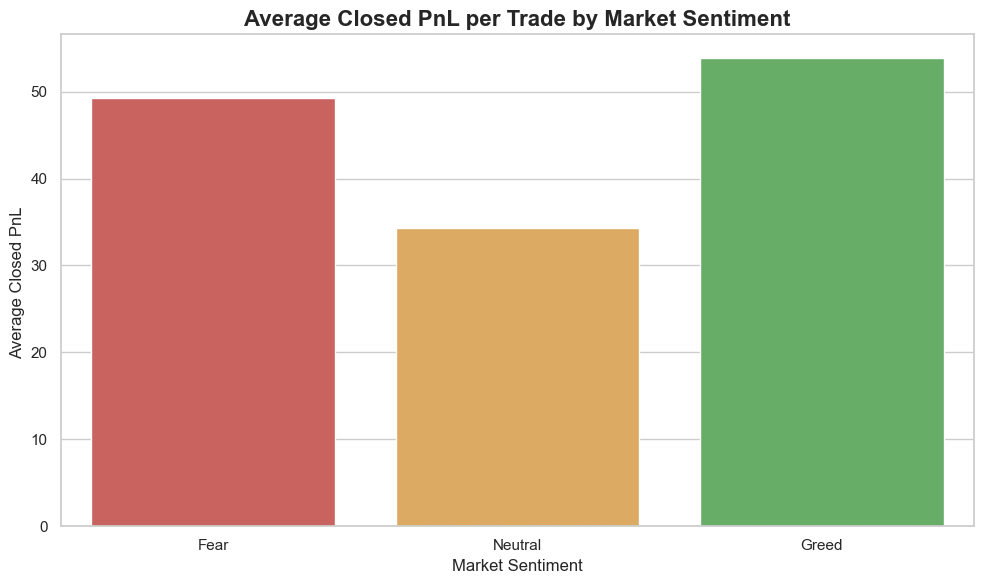


Analyzing Volume...

Total Volume  by Sentiment:
                  mean           sum
Sentiment                           
Fear       7182.011019  5.978091e+08
Neutral    4782.732661  1.802421e+08
Greed      4574.424490  4.130477e+08


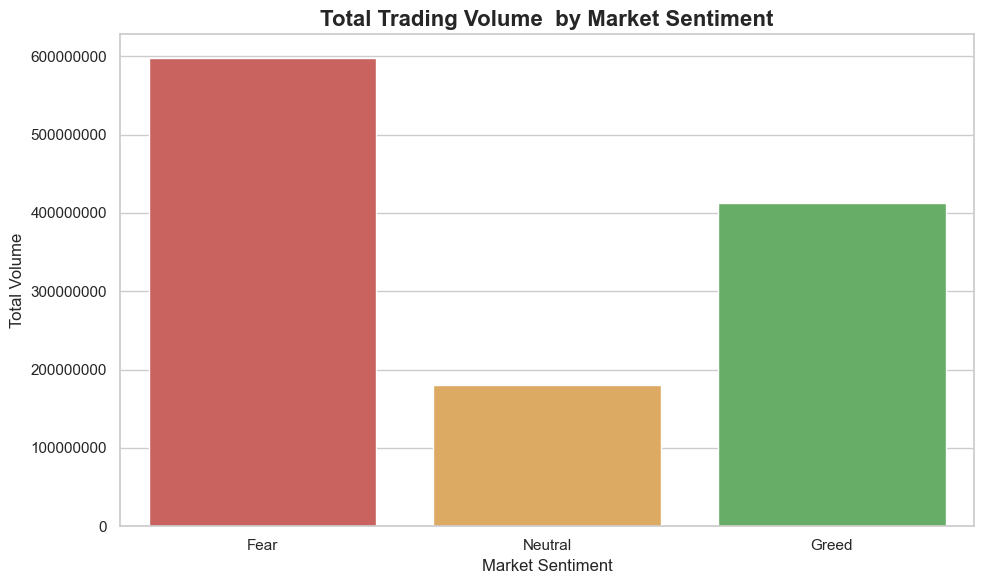


Analyzing Trader Behavior...

Total Buy/Sell Volume by Sentiment:
Side                BUY          SELL
Sentiment                            
Fear       3.032828e+08  2.945263e+08
Neutral    7.362647e+07  1.066156e+08
Greed      2.153212e+08  1.977265e+08


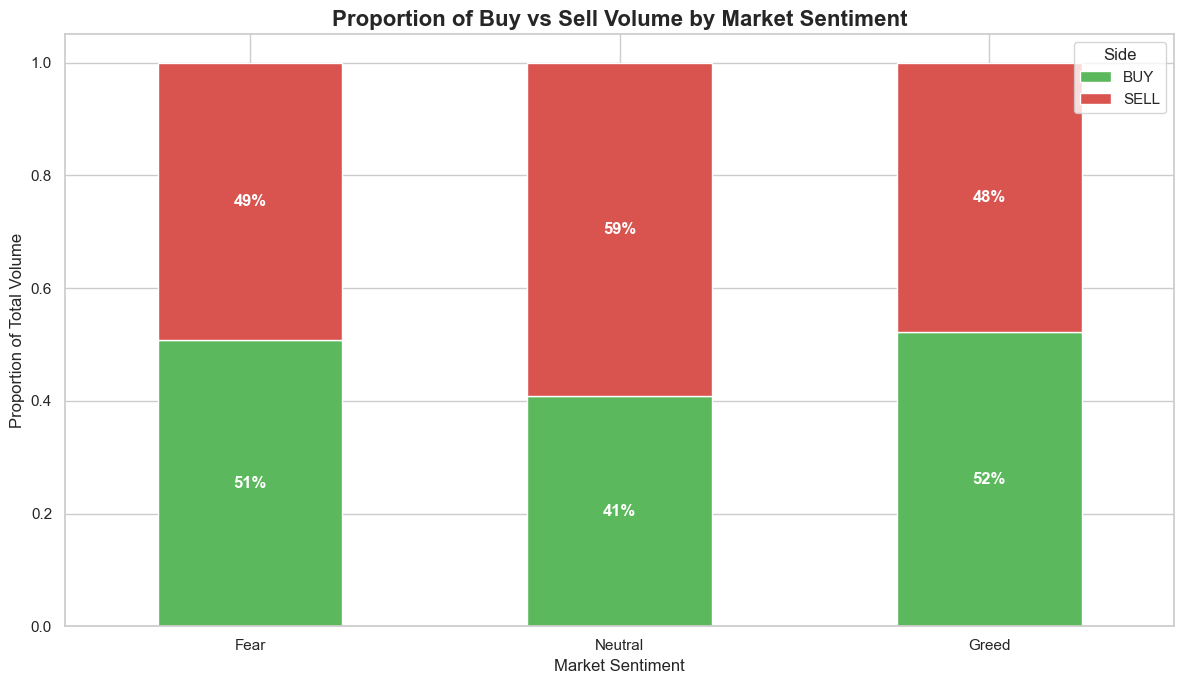


--- Analysis Complete ---


In [8]:
TRADER_DATA_FILE = 'D:/ds_Madheshwaran/CSV_files/historical_data.csv'
SENTIMENT_DATA_FILE = 'D:/ds_Madheshwaran/CSV_files/fear_greed_index.csv'
OUTPUT_PATH = 'D:/ds_Madheshwaran/outputs'

merged_data = load_data(TRADER_DATA_FILE, SENTIMENT_DATA_FILE)
if merged_data is not None:
    analyze_and_visualization(merged_data, OUTPUT_PATH)
